In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import collections
from IPython.display import Image
from networkx.algorithms import community
import matplotlib
matplotlib.rcParams['text.usetex'] = False
plt.style.use('seaborn-whitegrid')

COUNTRIES = ["USA", "China", "United Kingdom", "Australia"]
COORDINATES = {"USA": [-179, -66, 16, 60],
               "China": [70, 140, 15, 53],
               "United Kingdom": [-11, 2, 48, 60],
               "Australia": [111, 155, -42, -9]}

LBL_W = {"USA": 213000,             # 50
         "China": 51100,            # 75
         "United Kingdom": 48700,   # 17
         "Australia": 10704}           # 20

WIDTH_C = {"USA": 0.5,
           "China": 0.75,
           "United Kingdom": 0.9,
           "Australia": 5}


In [27]:
# Importing the data
airports_names = pd.read_csv("Airports.csv",encoding='unicode_escape')

#Importing the flights data
Flight_data = pd.read_csv("2003.csv")


In [28]:

# Cleaning the data

# set IATA/labels as index of df
airports_names = airports_names.set_index("id")

# Create data for requested countries: USA, China, UK, and Australia
Flight_data = Flight_data[Flight_data["Source Country"].isin(COUNTRIES)].reset_index(drop=True)

# Changing weights to integer values
Flight_data["Weight"] = Flight_data["Weight"].astype(int)

# ignoring time series
Flight_data = Flight_data.drop(["TimeSeries"], axis=1)


In [29]:
def NetworkGraph(country, airports_names=airports_names, routes=Flight_data, plot=True, output_g=False, output_all=False):
    country = "United Kingdom" if country.upper() == "UK" else country
    airport_country_filter = "United States" if country.upper() == "USA" else country
    airports_country = airports_names[airports_names["country"] == airport_country_filter]

    if country.upper() == "USA":
        airports_country = airports_country[airports_country["Lon"] != -70]

    routes_country = routes[routes["Source Country"] == country]
    routes_country = routes_country[routes_country["Source"].isin(airports_country.index) &
                                    routes_country["Target"].isin(airports_country.index)]

    weight_edges = routes_country[["Source", "Target", "Weight"]].values
    g = nx.Graph()
    g.add_weighted_edges_from(weight_edges)

    pos = {airport: (v["Lon"], v["Lat "]) for airport, v in
           airports_country.to_dict('index').items()}

    deg = nx.degree(g, weight='weight')
    all_sizes = [deg[iata] for iata in g.nodes]
    sizes = [(((deg[iata] - min(all_sizes)) * (300 - 17)) / (max(all_sizes) - min(all_sizes))) + 1 for iata in g.nodes]

    labels = {iata: iata if deg[iata] >= LBL_W[country] else ''
              for iata in g.nodes}

    all_weights = [data['weight'] for node1, node2, data in g.edges(data=True)]
    edge_width = [(((weight - min(all_weights)) * (WIDTH_C[country] - 0.075)) / (max(all_weights) - min(all_weights))) + 0.075
                  for weight in all_weights]

    if plot:
        crs = ccrs.PlateCarree()
        fig, ax = plt.subplots(
            1, 1, figsize=(17, 8),
            subplot_kw=dict(projection=crs))
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        # Extent of continental US.
        ax.set_extent(COORDINATES[country])
        ax.gridlines()
        nx.draw_networkx(g, ax=ax,
                         font_size=17,
                         alpha=.5,
                         width=edge_width,
                         node_size=sizes,
                         labels=labels,
                         pos=pos,
                         node_color=sizes,
                         cmap=plt.cm.plasma)
        plt.show()

    if output_all:
        return airports_country, routes_country, g, weight_edges, pos, deg, sizes, labels, all_weights, edge_width
    if output_g:
        return g

In [30]:
# plot degree distribution
def degree_distribution(deg, country):
    degree_sequence = sorted([d for n, d in deg], reverse=True)
    plt.semilogy(degree_sequence, marker="o", label="2003-07")
    plt.legend(loc="best")

    plt.title(r'Degree Distribution' + " for " + str(country))
    plt.ylabel(r"Weighted Degree")
    plt.xlabel(r"Rank")
    plt.show()

In [31]:
# degree vs betweenness distribution
def degree_betweenness(G, country):

    b = list(nx.betweenness_centrality(G, endpoints = False, normalized=False).items())
    x = [v for n, v in sorted(G.degree, key = lambda x: x[0], reverse  = False)]
    y = [v for n, v in sorted(b, key = lambda x: x[0], reverse  = False)]

    plt.plot(x, y, 'o')
    plt.legend(loc="best")
    plt.title(r'Degree vs Betweenness' + " for " + str(country))
    plt.ylabel(r"Betweenness")
    plt.xlabel(r"Weighted Degree")
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [32]:
# assortativity
def assort(G):
    r = nx.degree_pearson_correlation_coefficient(G, weight="weight")
    return r


# core community size
def core_community(G, country):
    # does what is explained on slide 51 of AVDC_2019-2022_AIAS_Lecture_Graph & Visualisation.pdf
    fig, ax = plt.subplots(1, 1, figsize=(17, 8))
    time_label = "2003-07"

    s = []

    try:
        core = nx.k_core(G, core_number=nx.core_number(G))
    except nx.exception.NetworkXError:
        g = G
        g.remove_edges_from(list(nx.selfloop_edges(g)))
        core = nx.k_core(g, core_number=nx.core_number(g))
    s.append(len(core))

    nx.draw_networkx(core, ax=ax, label=time_label, alpha=0.75, node_color="#DD8452", edge_color="#4C72B0")
    plt.legend(loc="best")
    plt.show()

    return s

def core_community_k(g, s, country):
    d = pd.DataFrame([(n, v) for (n, v) in sorted(G.degree, key = lambda x: x[1], reverse = True)]).rename(columns = {0:'id', 1:'degree'}, inplace = False)
    d['rank'] = d['degree'].rank(ascending = False)
    link_list = []
    for id in d['id']:
        count = 0
        for i in g.neighbors(id):
            if d[d['id'] == i].iloc[0]['degree'] > d[d['id'] == id].iloc[0]['degree']:
                count += 1
        link_list.append(count)
        
    x = pd.DataFrame([v for (n, v) in sorted(G.degree, key = lambda x: x[1], reverse = False)]).rank(axis = 0, method = 'first').to_numpy()
    y = link_list
    plt.plot(x, y)
    plt.title('Core Community Detection: {}'.format(country))
    plt.xlabel('Node Number - Ranked')
    plt.ylabel('No of connection to higher Degree Nodes')
    plt.xscale('linear')
    plt.yscale('linear')
    plt.legend(['Core Community Size: {}'.format(s)])
    plt.show()
                                                                                                     
                                                                                                    

# CHINA 


NETWORK GRAPH


C:\Users\HP\anaconda3\envs\Pantech\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


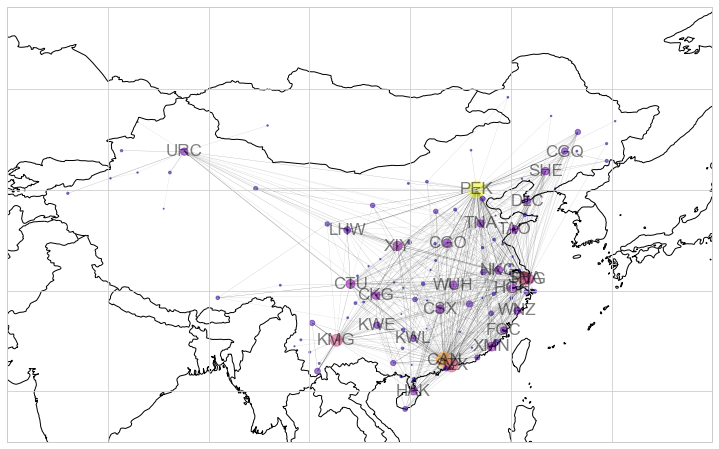

In [41]:

country = "China"   # Select the country.
G = NetworkGraph(country, routes=Flight_data, output_g=True)
deg = nx.degree(G, weight='weight')




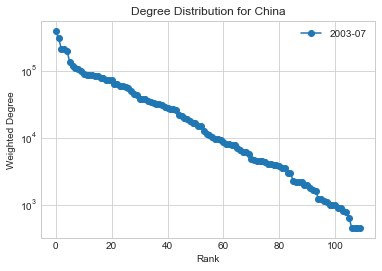

In [42]:
degree_distribution(deg, country)



In [43]:
r = assort(G)
print(f"{country} & {r} \\\\")



China & -0.3327296759706502 \\


C:\Users\HP\anaconda3\envs\Pantech\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


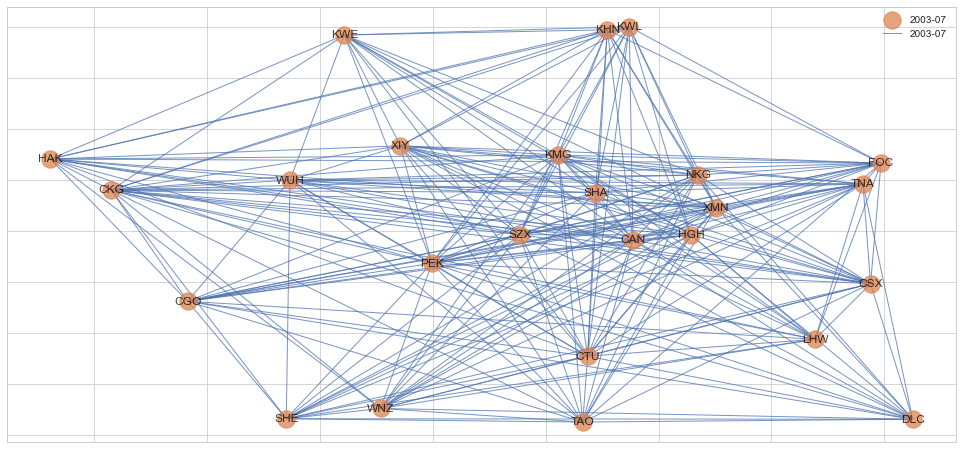

China & 25 \\


In [44]:
s = core_community(G, country)
print(f"{country} & {s[0]} \\\\")



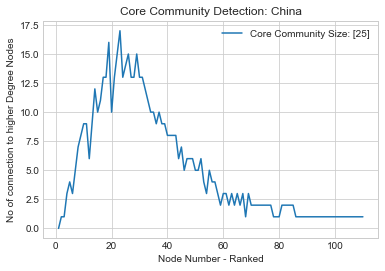

In [45]:
core_community_k(G, s, country)



No handles with labels found to put in legend.


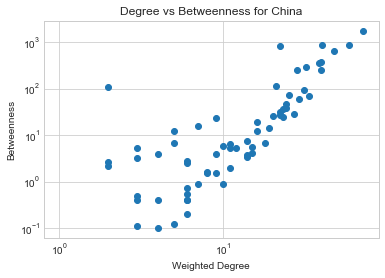

In [46]:
degree_betweenness(G, country)

# UK

C:\Users\HP\anaconda3\envs\Pantech\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


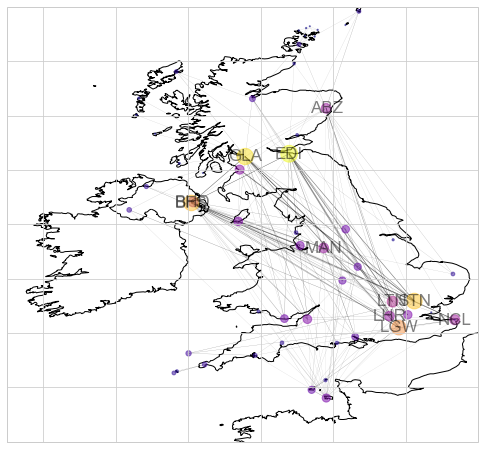

In [47]:

country = "UK"   # Select the country.
G = NetworkGraph(country, routes=Flight_data, output_g=True)
deg = nx.degree(G, weight='weight')




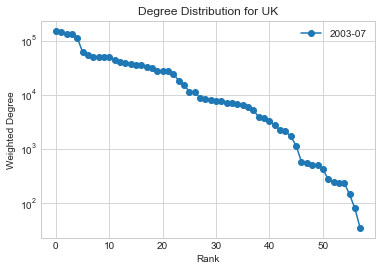

In [48]:
degree_distribution(deg, country)




In [49]:
r = assort(G)
print(f"{country} & {r} \\\\")



UK & 0.01803302093001415 \\


C:\Users\HP\anaconda3\envs\Pantech\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


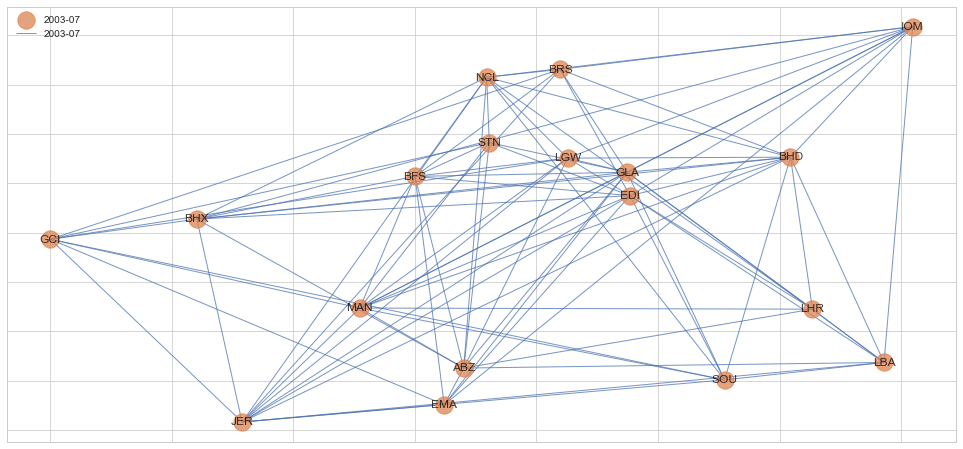

UK & 18 \\


In [50]:
s = core_community(G, country)
print(f"{country} & {s[0]} \\\\")



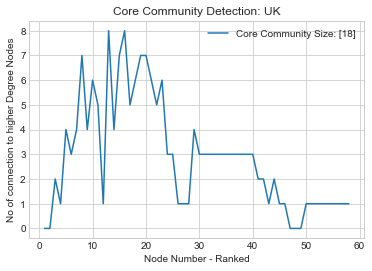

In [51]:
core_community_k(G, s, country)



No handles with labels found to put in legend.


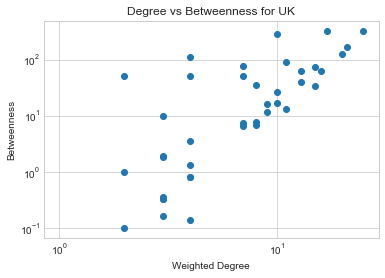

In [52]:
degree_betweenness(G, country)

# USA


C:\Users\HP\anaconda3\envs\Pantech\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


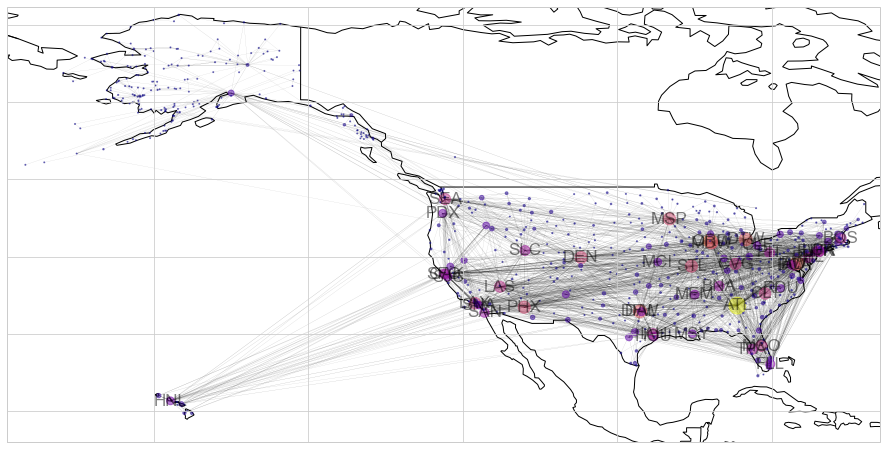

In [65]:

country = "USA"   # Select the country.
G = NetworkGraph(country, routes=Flight_data, output_g=True)
deg = nx.degree(G, weight='weight')


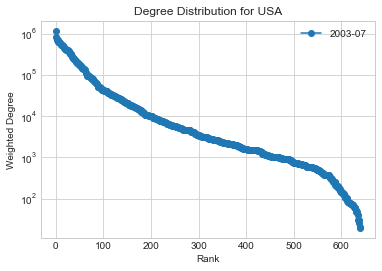

In [54]:
degree_distribution(deg, country)




In [55]:
r = assort(G)
print(f"{country} & {r} \\\\")



USA & -0.13009933797203682 \\


C:\Users\HP\anaconda3\envs\Pantech\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


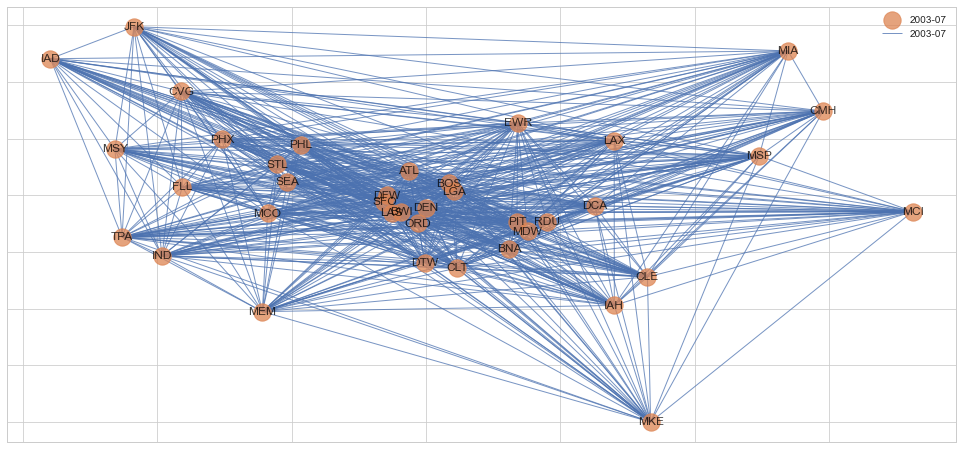

USA & 38 \\


In [56]:
s = core_community(G, country)
print(f"{country} & {s[0]} \\\\")



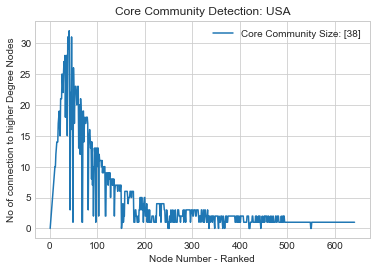

In [57]:
core_community_k(G, s, country)



No handles with labels found to put in legend.


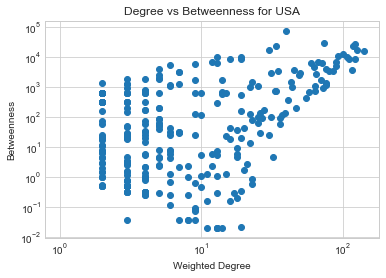

In [58]:
degree_betweenness(G, country)

# AUSTRALIA

C:\Users\HP\anaconda3\envs\Pantech\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


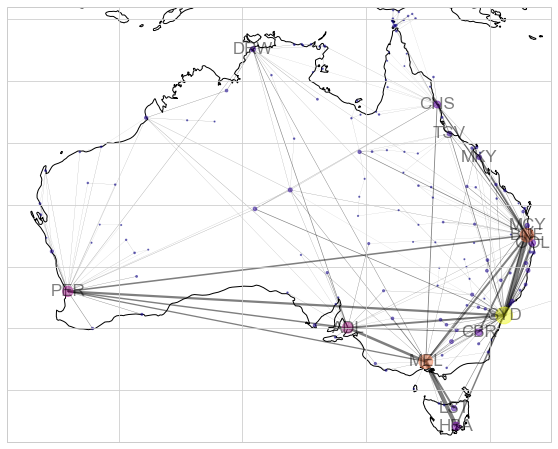

In [59]:

country = "Australia"   # Select the country.
G = NetworkGraph(country, routes=Flight_data, output_g=True)
deg = nx.degree(G, weight='weight')


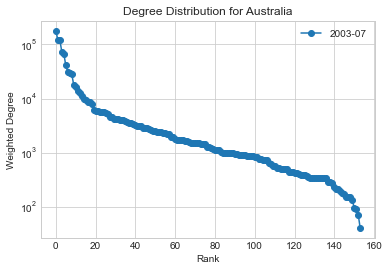

In [61]:
degree_distribution(deg, country)



In [60]:

r = assort(G)
print(f"{country} & {r} \\\\")



Australia & -0.12322653775586348 \\


C:\Users\HP\anaconda3\envs\Pantech\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


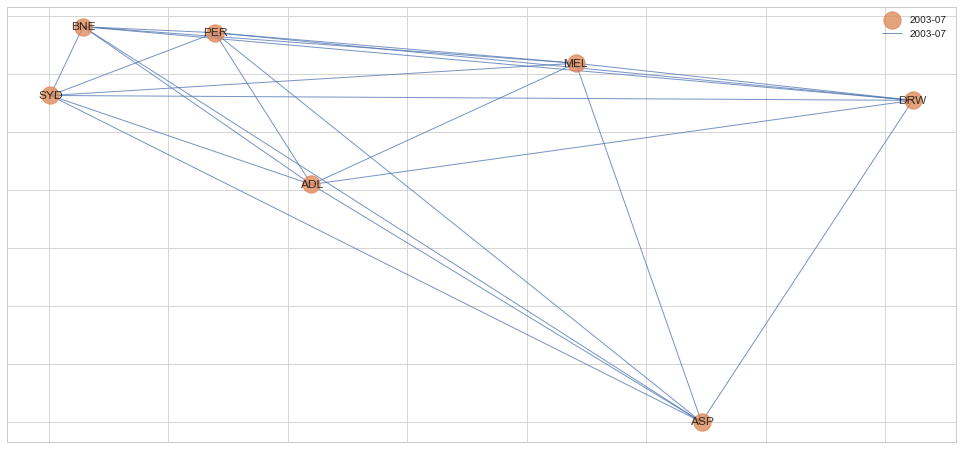

Australia & 7 \\


In [62]:
s = core_community(G, country)
print(f"{country} & {s[0]} \\\\")



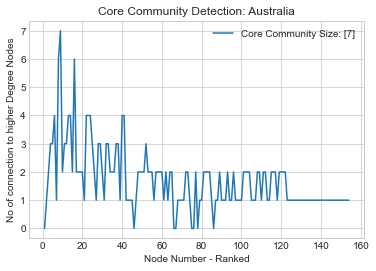

In [63]:
core_community_k(G, s, country)


No handles with labels found to put in legend.


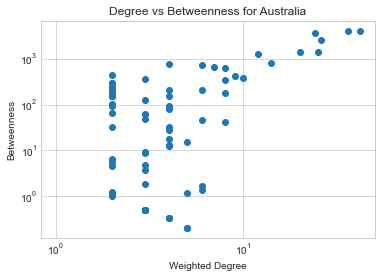

In [64]:

degree_betweenness(G, country)